# <font color='blue'>**LABORATORY 1: Traditional Computer Vision and CNNs Applied to Image Classification Problems**

<font color='red'>Members:

Sebastian Anderson Guerrero

Samantha Gallego Sanchez

Jesicca Lorena Arias Rios

<font color='red'>Code

Based on the general idea that a neural network architecture that works well for one computer vision problem will work well for any other problem in the same area, in this laboratory, you will be able to base your work on one of these architectures (i.e., LeNet, VGG, AlexNet) to create a CNN that allows you to classify the digits obtained from sign language.

You should follow the instructions (<font color='red'>highlighted in red</font>), which will guide you and also contribute to the final score obtained for this laboratory.

It is worth mentioning that throughout this document, the use of some Keras functions will be encouraged, as it is an excellent API that significantly reduces experimentation time.



##Libreries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as LK
import tensorflow.keras.models as MK
import cv2
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from tensorflow.keras import regularizers
from keras.layers.regularization.dropout import Dropout

In [2]:
#By Turkey Ankara Ayrancı Anadolu High School Students.

!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2095, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2095 (delta 2), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2095/2095), 15.07 MiB | 4.33 MiB/s, done.
Resolving deltas: 100% (660/660), done.


In [3]:
import os
import pathlib
sld_dir = pathlib.Path('Sign-Language-Digits-Dataset/Dataset/')
print(len(list(sld_dir.glob('*/*.JPG'))))


2062


##<font color='red'>Punto 1 (0.25). Lea la ayuda de la utilidad llamada **preprocessing.image_dataset_from_directory** de keras y utilicela para crear su dataset </font>.

Lea atentamente que parametros usted puede ingresarle a la función y tambien que es lo que la misma retorna.

Use el 80% de las imagenes para entrenamiento y el 20% para validación.

Cree los dos conjuntos: entrenamiento y validación.



In [4]:
data_dir = 'Sign-Language-Digits-Dataset/Dataset/'

In [5]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed = 112,
    label_mode = 'int',
    image_size = (100,100))

Found 2062 files belonging to 10 classes.
Using 1650 files for training.


In [6]:
data_test = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 112,
    label_mode = 'int',
    image_size = (100,100))

Found 2062 files belonging to 10 classes.
Using 412 files for validation.


## <font color='red'>Task 2 (0.25). Understanding the dataset</font>

The two datasets created in Task 1 have a specific structure for handling images and labels.

Based on the code shown in class to display the first 5 images from the MNIST dataset, modify it to display 9 images from the training dataset, with each image presenting its label at the top.

Here are some tips:

* Assuming your training dataset is named ***sld_train***, you can find the class names using: **class_names = sld_train.class_names**

* If you iterate over the ***sld_train*** dataset using a for loop, it will return two arrays: images and labels.

* Keep in mind that to visualize this type of image, you need to convert them. For example: **image[i].numpy().astype('uint8')**.





In [7]:
class_names = data_train.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


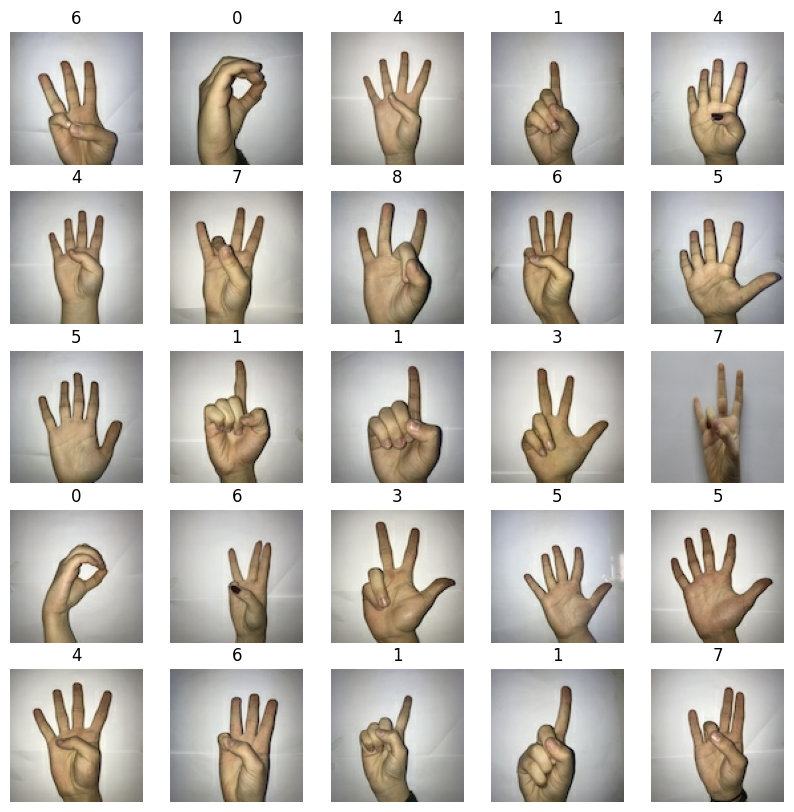

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## <font color='red'>Task 3 (0.25). Read the documentation of the utility called **experimental.preprocessing.Rescaling** from Keras and use it to normalize your datasets.</font>

Carefully read about the parameters you can pass to the function and what it returns.

Although it is not necessary, if you wish, you can iterate over the normalized dataset and save them in the variables x_train, y_train, x_test, and y_test used in class. For this, you might need a line of code similar to this: **x_train, y_train = next(iter(normalized_data))**.

In [9]:
normalization_layer = LK.Rescaling(1./255)

train_normalizado = data_train.map(lambda x, y: (normalization_layer(x), y))
x_train_b, y_train_b = next(iter(train_normalizado))

test_normalizado = data_test.map(lambda x, y: (normalization_layer(x), y))
x_test_b, y_test_b = next(iter(test_normalizado))

## <font color='red'>Task 4 (1.5). Create a traditional classifier for the given dataset.

Utilize the knowledge acquired in class about traditional computer vision techniques: detectors/descriptors, Bag-of-Visual-Words (BoVW), and Artificial Neural Networks (ANNs) to create, train, and validate a TRADITIONAL CLASSIFIER.
Remember to obtain metrics that can be compared with the CNN classifier.


In [10]:
data_train_ub = data_train.unbatch()
data_test_ub = data_test.unbatch()

In [11]:
def unir_dataset(dataset_ub):
  x = []
  y = []

  for i, j in dataset_ub:
    x.append(i.numpy().astype("uint8"))
    y.append(j.numpy().astype("uint8"))

  x = np.array(x)
  y = np.array(y)
  return x, y

In [12]:
x_train, y_train = unir_dataset(data_train_ub)
x_test, y_test = unir_dataset(data_test_ub)

In [13]:
print("Training Images: {}, Labels: {}" .format(x_train.shape, y_train.shape))
print("Testing Images: {}, Labels: {}" .format(x_test.shape, y_test.shape))

Training Images: (1650, 100, 100, 3), Labels: (1650,)
Testing Images: (412, 100, 100, 3), Labels: (412,)


In [14]:
x_train_gray = []
for i in range(len(x_train)):
  x_train_gray.append(cv2.cvtColor(x_train[i], cv2.COLOR_RGB2GRAY))
x_train_gray = np.array(x_train_gray)

x_test_gray = []
for i in range(len(x_test)):
  x_test_gray.append(cv2.cvtColor(x_test[i], cv2.COLOR_RGB2GRAY))
x_test_gray = np.array(x_test_gray)

In [16]:
print("Training Images: {}, Labels: {}" .format(x_train_gray.shape, y_train.shape))
print("Testing Images: {}, Labels: {}" .format(x_test_gray.shape, y_test.shape))

Training Images: (1650, 100, 100), Labels: (1650,)
Testing Images: (412, 100, 100), Labels: (412,)


In [17]:
def CreateDict(x, y):

  dic = {}

  for label in set(y):
    cat = []
    for i in range(len(x)):
      if (y[i] == label):
        cat.append(x[i])
    dic[str(label)] = cat

  return dic

In [18]:
train = CreateDict(x_train_gray,y_train)

In [19]:
def sift_feat(imagenes):
  sift = cv2.SIFT_create()
  sift_featXcat = {}
  sift_feat_all = []
  for key,value in imagenes.items():
    featXcat=[]
    for img in value:
      kp, desc = sift.detectAndCompute(img, None)
      sift_feat_all.extend(desc)
      featXcat.append(desc)
    sift_featXcat[key] = featXcat
  return[sift_feat_all, sift_featXcat]

In [20]:
sifts = sift_feat(train)

In [21]:
feat_all = sifts[0]
train_bovw_feat = sifts[1]

In [22]:
def kmeans(k, lista):
  kmeans = KMeans(n_clusters = k)
  kmeans.fit(lista)
  visual_words  = kmeans.cluster_centers_
  return visual_words

In [23]:
k = 50   # Number of words
visual_words = kmeans(k, feat_all)

In [24]:
print(visual_words.shape)

(50, 128)


In [25]:
def find_idx(feat, center):
  count=0
  ind=0
  for i in range(len(center)):
    if (i==0):
      count = distance.euclidean(feat, center[i])
    else:
      dist = distance.euclidean(feat, center[i])
      if (dist < count):
        ind = i
        count=dist
  return ind

In [26]:
def img_clases(bovw_feat, centers):
  dict_feat = {}
  for key, value in bovw_feat.items():
    imagens = []
    for img in value:
      histo = np.zeros(len(centers))
      for each_feat in img:
        idx = find_idx(each_feat, centers)
        histo[idx] += 1
      imagens.append(histo)
    dict_feat[key] = imagens
  return dict_feat

In [27]:
bovw_train = img_clases(train_bovw_feat, visual_words)

In [28]:
def prepare_data(diccio):
  y = []
  x = []
  for key, values in diccio.items():
    for histo in values:
      x.append(histo)
      y.append(key)
  return np.array(x), np.array(y)

In [29]:
x_train_red, y_train_red = prepare_data(bovw_train)

In [30]:
print(x_train_red.shape)
print(y_train_red.shape)

(1650, 50)
(1650,)


In [31]:
test = CreateDict(x_test_gray, y_test)

In [32]:
test_bovw_feat = sift_feat(test)[1]

In [33]:
bovw_test = img_clases(test_bovw_feat, visual_words)

In [34]:
x_test_red, y_test_red = prepare_data(bovw_test)

In [35]:
print(x_test_red.shape)
print(y_test_red.shape)

(412, 50)
(412,)


In [36]:
std = StandardScaler().fit(x_train_red)
x_train_red = std.transform(x_train_red)

In [37]:
x_test_red = std.transform(x_test_red)

In [38]:
mlp = MLPClassifier(hidden_layer_sizes=(80,5), activation='relu', solver='adam', max_iter=1)
n_epochs = 600
N_CLASSES = np.unique(y_train_red)

accuracy_mlp = []
accuracy_test_mlp = []

for i in range(n_epochs):
  mlp.partial_fit(x_train_red, y_train_red, classes=N_CLASSES)

  accuracy_mlp.append(mlp.score(x_train_red, y_train_red))
  accuracy_test_mlp.append(mlp.score(x_test_red, y_test_red))

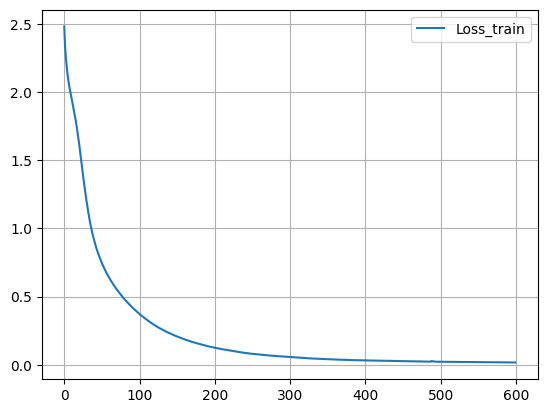

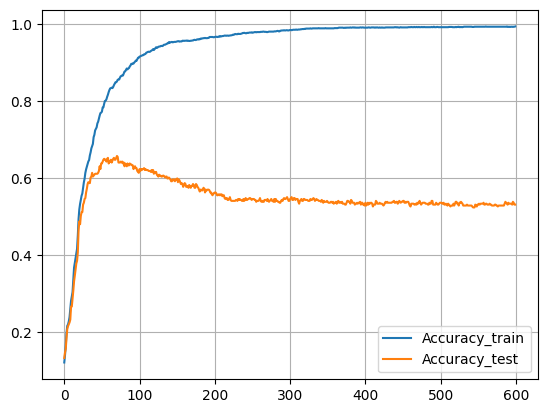

In [39]:
plt.plot(mlp.loss_curve_, label = 'Loss_train')
plt.legend()
plt.grid()
plt.show()

plt.plot(accuracy_mlp, label = 'Accuracy_train')
plt.plot(accuracy_test_mlp, label = 'Accuracy_test')
plt.legend()
plt.grid()
plt.show()

In [40]:
p = mlp.predict(x_test_red)

In [41]:
acc_test = accuracy_score(y_test_red, p)
print('The accuracy of our network is:', str(acc_test))

The accuracy of our network is: 0.5315533980582524


In [42]:
M = confusion_matrix(y_test_red, p)

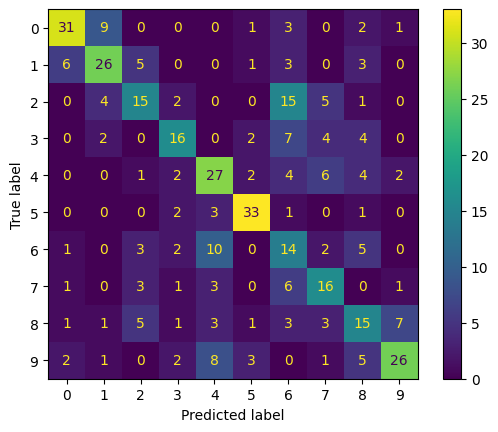

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix = M,
                              display_labels = mlp.classes_)
disp.plot()
plt.show()

In [44]:
print(classification_report(y_test_red, p))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70        47
           1       0.60      0.59      0.60        44
           2       0.47      0.36      0.41        42
           3       0.57      0.46      0.51        35
           4       0.50      0.56      0.53        48
           5       0.77      0.82      0.80        40
           6       0.25      0.38      0.30        37
           7       0.43      0.52      0.47        31
           8       0.38      0.38      0.38        40
           9       0.70      0.54      0.61        48

    accuracy                           0.53       412
   macro avg       0.54      0.53      0.53       412
weighted avg       0.55      0.53      0.54       412



## <font color='red'>Task 5 (0.25). Creating the basic CNN architecture</font>
Create an architecture based on one of the proposed models. For this part, your model should be complete (including all convolutional, pooling, and fully connected layers), but should not have any type of regularization.

Provide a brief explanation (no more than 10 lines) about the architecture used and the reason for your selection.

Display the summary of your model at the end and choose the optimization method that will be used (this can be modified during training if necessary).

In [45]:
x_train_n = (x_train - x_train.min())/(x_train.max()-x_train.min())
x_test_n = (x_test - x_test.min())/(x_test.max()-x_test.min())

In [47]:
# Create the LeNet model
input = LK.Input(shape=(100,100,3))
conv1 = LK.Conv2D(6,5,padding='same',activation='relu')(input)
pool1 = LK.MaxPool2D((2,2),(2,2))(conv1)
conv2 = LK.Conv2D(16,5,padding='valid',activation='relu')(pool1)
pool2 = LK.MaxPool2D((2,2),(2,2))(conv2)
flat = LK.Flatten()(pool2)
fc1 = LK.Dense(120,activation='relu')(flat)
fc2 = LK.Dense(84,activation='relu')(fc1)
output = LK.Dense(10,activation='sigmoid')(fc2)

modelo = MK.Model(input,output)
modelo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 6)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8464)              0     

In [48]:
optimo= 'adam'
modelo.compile(optimizer=optimo, loss='categorical_crossentropy',metrics=['accuracy'] )

In [49]:
num_classes = 10
y_train_ohe = keras.utils.to_categorical(y_train,num_classes)
y_test_ohe = keras.utils.to_categorical(y_test,num_classes)

In [50]:
history = modelo.fit(x_train_n, y_train_ohe, epochs=25, batch_size=64, validation_data=(x_test_n,y_test_ohe), verbose=1)
loss, acc = modelo.evaluate(x_test_n,y_test_ohe, verbose=1)
print('Loss:{0} - Accuracy:{1}'.format(loss,acc))

Epoch 1/25
26/26 [==============================] - 13s 39ms/step - loss: 2.2659 - accuracy: 0.1836 - val_loss: 2.0036 - val_accuracy: 0.4927
Epoch 2/25
26/26 [==============================] - 0s 14ms/step - loss: 1.3452 - accuracy: 0.5721 - val_loss: 1.0555 - val_accuracy: 0.6408
Epoch 3/25
26/26 [==============================] - 0s 13ms/step - loss: 0.7268 - accuracy: 0.7576 - val_loss: 0.7701 - val_accuracy: 0.7330
Epoch 4/25
26/26 [==============================] - 0s 13ms/step - loss: 0.5071 - accuracy: 0.8442 - val_loss: 0.6296 - val_accuracy: 0.7961
Epoch 5/25
26/26 [==============================] - 0s 14ms/step - loss: 0.3596 - accuracy: 0.8933 - val_loss: 0.5687 - val_accuracy: 0.8034
Epoch 6/25
26/26 [==============================] - 0s 13ms/step - loss: 0.3191 - accuracy: 0.9018 - val_loss: 0.5519 - val_accuracy: 0.8180
Epoch 7/25
26/26 [==============================] - 0s 14ms/step - loss: 0.2217 - accuracy: 0.9388 - val_loss: 0.5128 - val_accuracy: 0.8228
Epoch 8/25
2

## <font color='red'>Task *6* (0.5). Training and validating your CNN model</font>

Train your basic model, obtain the accuracy and loss graphs, and draw your own conclusions.



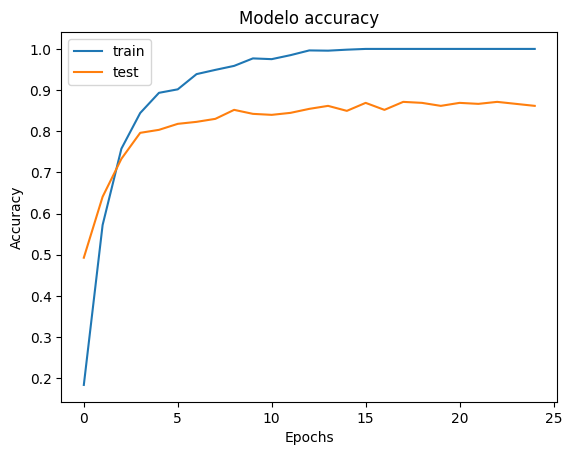

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

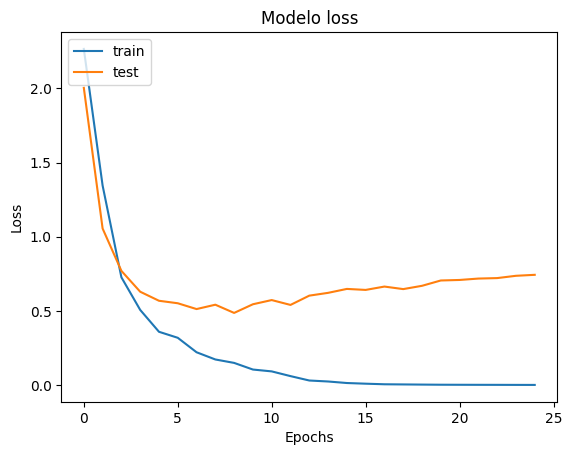

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [53]:
p = modelo.predict(x_test_n)

13/13 [==============================] - 0s 4ms/step


In [54]:
loss, acc = modelo.evaluate(x_test_n,y_test_ohe, verbose=1)
print('Loss:{0} - Accuracy:{1}'.format(loss,acc))

13/13 [==============================] - 0s 5ms/step - loss: 0.7435 - accuracy: 0.8617
Loss:0.743514358997345 - Accuracy:0.8616504669189453


In [55]:
M = confusion_matrix(y_test, p.argmax(1))

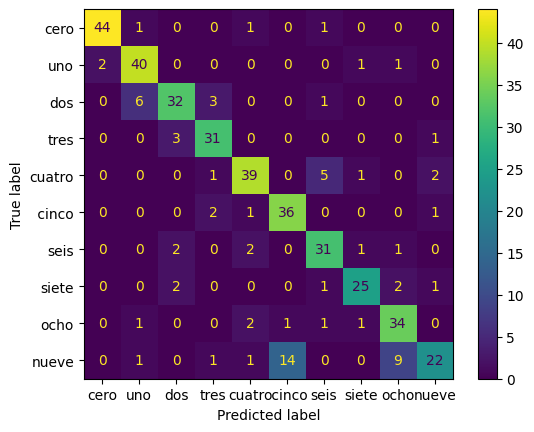

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix = M,
                              display_labels =['cero', 'uno', 'dos', 'tres', 'cuatro', ' cinco', 'seis', 'siete', 'ocho', 'nueve'])
disp.plot()
plt.show()

In [57]:
print(classification_report(y_test, p.argmax(1)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        47
           1       0.82      0.91      0.86        44
           2       0.82      0.76      0.79        42
           3       0.82      0.89      0.85        35
           4       0.85      0.81      0.83        48
           5       0.71      0.90      0.79        40
           6       0.78      0.84      0.81        37
           7       0.86      0.81      0.83        31
           8       0.72      0.85      0.78        40
           9       0.81      0.46      0.59        48

    accuracy                           0.81       412
   macro avg       0.81      0.82      0.81       412
weighted avg       0.82      0.81      0.81       412



## <font color='red'>Task **7** (1.0). Improving your CNN</font>

Make use of regularization methods that you consider appropriate (can be more than one) to significantly reduce overfitting.

You can train the network as many times as you want, changing the regularization methods, but make sure to document two different models in this report (logically, they should be the two best ones).

Create a comparative table showing the differences between your base CNN model, the two models with regularization, and the traditional model.

###Drop

In [ ]:
#Dropout
entrada = LK.Input(shape=(100,100,3))
conv1 = LK.Conv2D(6,5,padding='same',activation='relu')(entrada)
pool1 = LK.MaxPool2D((2,2),(2,2))(conv1)
conv2 = LK.Conv2D(16,5,padding='valid',activation='relu')(pool1)
drop = LK.Dropout(0.3)(conv2)
pool2 = LK.MaxPool2D((2,2),(2,2))(drop)
flat = LK.Flatten()(pool2)
fc1 = LK.Dense(120,activation='relu')(flat)
drop2 = LK.Dropout(0.3)(fc1)
fc2 = LK.Dense(84,activation='relu')(drop2)
salida = LK.Dense(10,activation='sigmoid')(fc2)

modelo_drop = MK.Model(entrada,salida)
modelo_drop.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 6)       456       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 46, 16)        2416      
                                                                 
 dropout (Dropout)           (None, 46, 46, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                       

In [ ]:
#Compilar el modelo
modelo_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_drop = modelo_drop.fit(x_train_n, y_train_ohe, epochs=50, batch_size=64, validation_data=(x_test_n,y_test_ohe), verbose=1)


Epoch 1/50
26/26 [==============================] - 3s 37ms/step - loss: 2.0947 - accuracy: 0.2642 - val_loss: 1.5681 - val_accuracy: 0.5850
Epoch 2/50
26/26 [==============================] - 1s 26ms/step - loss: 1.1407 - accuracy: 0.6194 - val_loss: 0.8749 - val_accuracy: 0.7306
Epoch 3/50
26/26 [==============================] - 1s 25ms/step - loss: 0.7794 - accuracy: 0.7242 - val_loss: 0.7489 - val_accuracy: 0.7670
Epoch 4/50
26/26 [==============================] - 1s 22ms/step - loss: 0.6244 - accuracy: 0.7988 - val_loss: 0.5920 - val_accuracy: 0.8252
Epoch 5/50
26/26 [==============================] - 1s 20ms/step - loss: 0.4799 - accuracy: 0.8394 - val_loss: 0.5597 - val_accuracy: 0.8131
Epoch 6/50
26/26 [==============================] - 1s 22ms/step - loss: 0.4238 - accuracy: 0.8624 - val_loss: 0.4836 - val_accuracy: 0.8374
Epoch 7/50
26/26 [==============================] - 0s 19ms/step - loss: 0.3314 - accuracy: 0.8897 - val_loss: 0.4537 - val_accuracy: 0.8714
Epoch 8/50
26

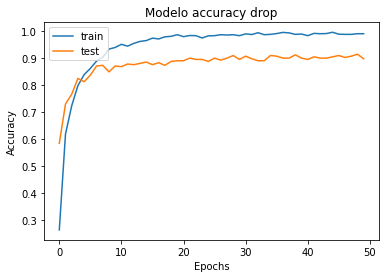

In [ ]:
plt.plot(history_drop.history['accuracy'])
plt.plot(history_drop.history['val_accuracy'])
plt.title('Modelo accuracy drop')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

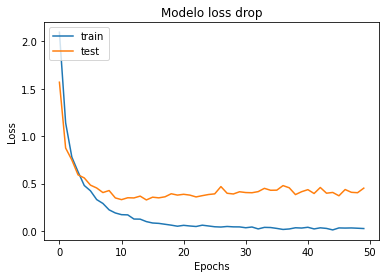

In [ ]:
plt.plot(history_drop.history['loss'])
plt.plot(history_drop.history['val_loss'])
plt.title('Modelo loss drop')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
p_drop = modelo_drop.predict(x_test_n)

13/13 [==============================] - 0s 4ms/step


In [ ]:
loss_drop, acc_drop = modelo_drop.evaluate(x_test_n,y_test_ohe, verbose=1)
print('Loss:{0} - Accuracy:{1}'.format(loss_drop,acc_drop))

13/13 [==============================] - 0s 8ms/step - loss: 0.4520 - accuracy: 0.8981
Loss:0.4519743025302887 - Accuracy:0.8980582356452942


In [ ]:
M_drop = confusion_matrix(y_test, p_drop.argmax(1))

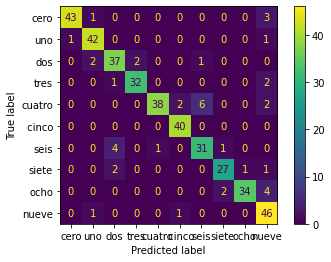

In [ ]:
disp_drop = ConfusionMatrixDisplay(confusion_matrix = M_drop,
                              display_labels =['cero', 'uno', 'dos', 'tres', 'cuatro', ' cinco', 'seis', 'siete', 'ocho', 'nueve'])
disp_drop.plot()
plt.show()

In [ ]:
print(classification_report(y_test, p_drop.argmax(1)))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95        47
           1       0.91      0.95      0.93        44
           2       0.84      0.88      0.86        42
           3       0.94      0.91      0.93        35
           4       0.97      0.79      0.87        48
           5       0.93      1.00      0.96        40
           6       0.82      0.84      0.83        37
           7       0.90      0.87      0.89        31
           8       0.97      0.85      0.91        40
           9       0.78      0.96      0.86        48

    accuracy                           0.90       412
   macro avg       0.90      0.90      0.90       412
weighted avg       0.90      0.90      0.90       412



###Drop L2

In [68]:
#Dropout L2
entrada = LK.Input(shape=(100,100,3))
conv1 = LK.Conv2D(6,5,padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01))(entrada)
pool1 = LK.MaxPool2D((2,2),(2,2))(conv1)
conv2 = LK.Conv2D(16,5,padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01))(pool1)
drop = LK.Dropout(0.3)(conv2)
pool2 = LK.MaxPool2D((2,2),(2,2))(drop)
flat = LK.Flatten()(pool2)
fc1 = LK.Dense(120,activation='relu', kernel_regularizer=regularizers.L2(0.01))(flat)
drop2 = LK.Dropout(0.3)(fc1)
fc2 = LK.Dense(84,activation='relu', kernel_regularizer=regularizers.L2(0.01))(drop2)
salida = LK.Dense(10,activation='sigmoid')(fc2)

modelo_drop_l2 = MK.Model(entrada,salida)
modelo_drop_l2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 6)       456       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 6)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 16)        2416      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                       

In [69]:
#Compilar el modelo
modelo_drop_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
history_drop_l2 = modelo_drop_l2.fit(x_train_n, y_train_ohe, epochs=50, batch_size=64, validation_data=(x_test_n,y_test_ohe), verbose=1)


Epoch 1/50
26/26 [==============================] - 3s 54ms/step - loss: 4.2409 - accuracy: 0.1091 - val_loss: 3.3822 - val_accuracy: 0.1092
Epoch 2/50
26/26 [==============================] - 1s 22ms/step - loss: 3.1264 - accuracy: 0.2218 - val_loss: 2.8567 - val_accuracy: 0.3665
Epoch 3/50
26/26 [==============================] - 0s 19ms/step - loss: 2.4138 - accuracy: 0.4115 - val_loss: 1.9563 - val_accuracy: 0.6117
Epoch 4/50
26/26 [==============================] - 0s 19ms/step - loss: 1.7861 - accuracy: 0.5855 - val_loss: 1.6100 - val_accuracy: 0.7063
Epoch 5/50
26/26 [==============================] - 0s 19ms/step - loss: 1.4609 - accuracy: 0.6842 - val_loss: 1.3605 - val_accuracy: 0.7670
Epoch 6/50
26/26 [==============================] - 0s 16ms/step - loss: 1.2538 - accuracy: 0.7315 - val_loss: 1.2042 - val_accuracy: 0.7791
Epoch 7/50
26/26 [==============================] - 0s 16ms/step - loss: 1.1338 - accuracy: 0.7636 - val_loss: 1.0840 - val_accuracy: 0.8083
Epoch 8/50
26

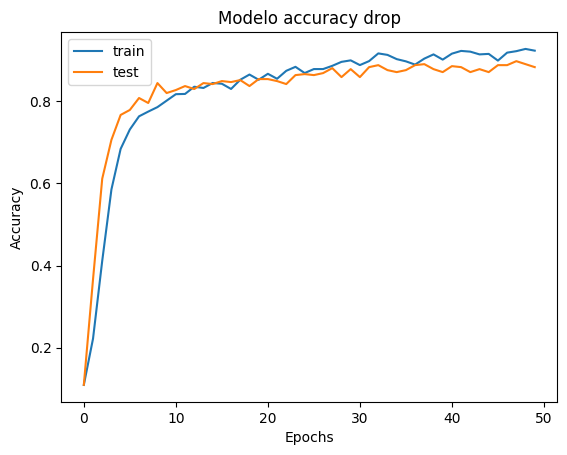

In [71]:
plt.plot(history_drop_l2.history['accuracy'])
plt.plot(history_drop_l2.history['val_accuracy'])
plt.title('Modelo accuracy drop')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

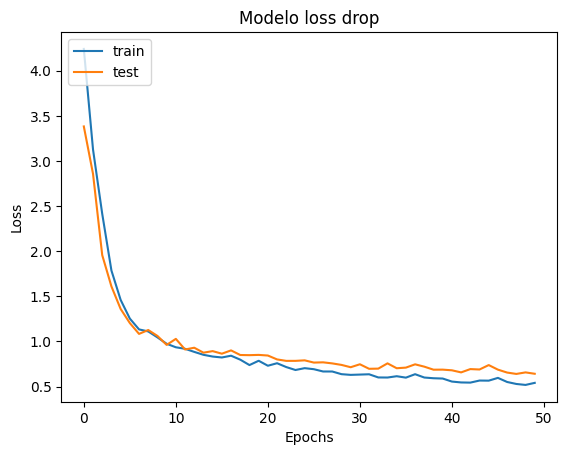

In [72]:
plt.plot(history_drop_l2.history['loss'])
plt.plot(history_drop_l2.history['val_loss'])
plt.title('Modelo loss drop')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [73]:
p_drop_l2 = modelo_drop_l2.predict(x_test_n)

13/13 [==============================] - 0s 4ms/step


In [74]:
loss_drop_l2, acc_drop_l2 = modelo_drop_l2.evaluate(x_test_n,y_test_ohe, verbose=1)
print('Loss:{0} - Accuracy:{1}'.format(loss_drop_l2,acc_drop_l2))

13/13 [==============================] - 0s 5ms/step - loss: 0.6424 - accuracy: 0.8835
Loss:0.6423672437667847 - Accuracy:0.8834951519966125


In [75]:
M_drop_l2 = confusion_matrix(y_test, p_drop_l2.argmax(1))

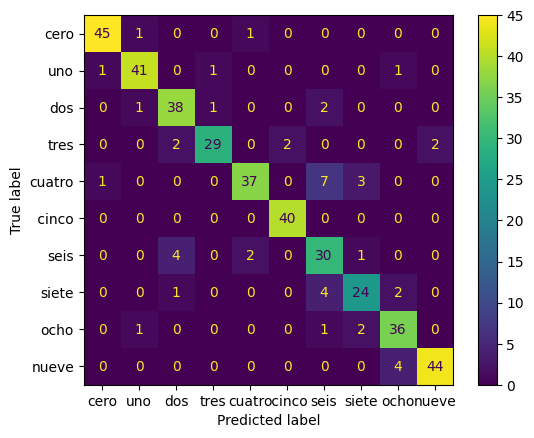

In [76]:
disp_drop_l2 = ConfusionMatrixDisplay(confusion_matrix = M_drop_l2,
                              display_labels =['cero', 'uno', 'dos', 'tres', 'cuatro', ' cinco', 'seis', 'siete', 'ocho', 'nueve'])
disp_drop_l2.plot()
plt.show()

In [77]:
print(classification_report(y_test, p_drop_l2.argmax(1)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        47
           1       0.93      0.93      0.93        44
           2       0.84      0.90      0.87        42
           3       0.94      0.83      0.88        35
           4       0.93      0.77      0.84        48
           5       0.95      1.00      0.98        40
           6       0.68      0.81      0.74        37
           7       0.80      0.77      0.79        31
           8       0.84      0.90      0.87        40
           9       0.96      0.92      0.94        48

    accuracy                           0.88       412
   macro avg       0.88      0.88      0.88       412
weighted avg       0.89      0.88      0.88       412



###Comparation

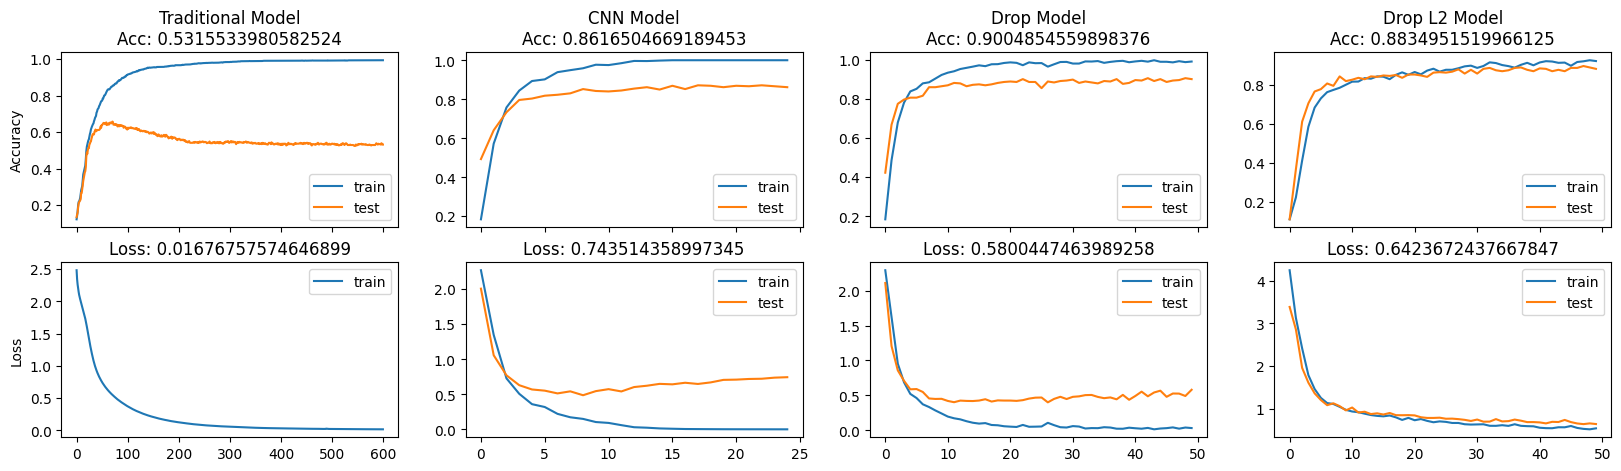

In [78]:
plt.figure(figsize=(20,5))

plt.subplot(2,4,1)
plt.plot(accuracy_mlp, label = 'Accuracy_train')
plt.plot(accuracy_test_mlp, label = 'Accuracy_test')
plt.title('Traditional Model\nAcc: '+str(acc_test))
plt.ylabel('Accuracy')
plt.gca().set_xticklabels([])
plt.legend(['train','test'], loc='lower right')

plt.subplot(2,4,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model\nAcc: '+str(acc))
plt.gca().set_xticklabels([])
plt.legend(['train','test'], loc='lower right')

plt.subplot(2,4,3)
plt.plot(history_drop.history['accuracy'])
plt.plot(history_drop.history['val_accuracy'])
plt.title('Drop Model\nAcc: '+str(acc_drop))
plt.gca().set_xticklabels([])
plt.legend(['train','test'], loc='lower right')

plt.subplot(2,4,4)
plt.plot(history_drop_l2.history['accuracy'])
plt.plot(history_drop_l2.history['val_accuracy'])
plt.title('Drop L2 Model\nAcc: '+str(acc_drop_l2))
plt.gca().set_xticklabels([])
plt.legend(['train','test'], loc='lower right')

plt.subplot(2,4,5)
plt.plot(mlp.loss_curve_, label = 'Loss_train')
plt.title('Loss: '+str(mlp.loss_))
plt.ylabel('Loss')
plt.legend(['train'], loc='upper right')

plt.subplot(2,4,6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss: '+str(loss))
plt.legend(['train','test'], loc='upper right')

plt.subplot(2,4,7)
plt.plot(history_drop.history['loss'])
plt.plot(history_drop.history['val_loss'])
plt.title('Loss: '+str(loss_drop))
plt.legend(['train','test'], loc='upper right')

plt.subplot(2,4,8)
plt.plot(history_drop_l2.history['loss'])
plt.plot(history_drop_l2.history['val_loss'])
plt.title('Loss: '+str(loss_drop_l2))
plt.legend(['train','test'], loc='upper right')
plt.show()


## <font color='red'>Task 8 (1.0). Additional Testing of Your Best Classifier</font>

Create a set of 20 images, showing different digits of sign language. Develop a program that reads the images, preprocesses them, and prepares them as input for your best classifier. Display the processed images and the predicted value of your network with a percentage.

In [79]:
# Custom Dataset
!git clone https://github.com/Jessica-Arias/ComputerVision_DeepLearning.git

Cloning into 'ComputerVision_DeepLearning'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 140 (delta 28), reused 6 (delta 6), pack-reused 81
Receiving objects: 100% (140/140), 38.01 MiB | 8.93 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [80]:
!mv ComputerVision_DeepLearning/CVwDL_20231/Prueba_lab1 /content/

In [81]:
prueba_dir = pathlib.Path('/content/Prueba_lab1/')
print(len(list(prueba_dir.glob('*/*.jpg'))))

20


In [82]:
prueba_dir = '/content/Prueba_lab1/'

In [83]:
data_prueba = tf.keras.utils.image_dataset_from_directory(
    prueba_dir,
    label_mode = 'int',
    image_size = (100,100))

Found 20 files belonging to 10 classes.


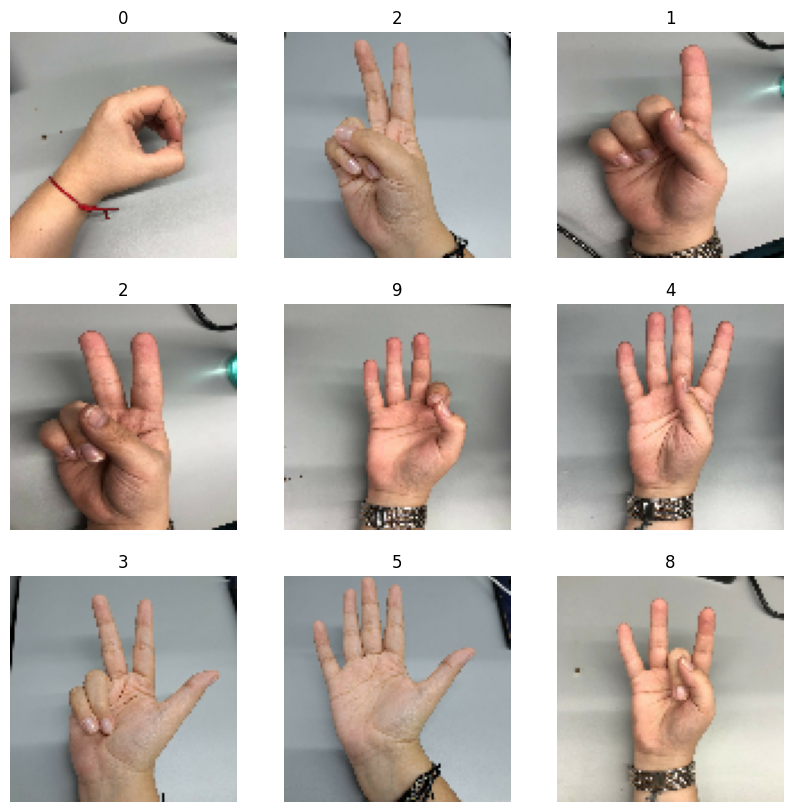

In [84]:
plt.figure(figsize=(10, 10))
for images, labels in data_prueba.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [85]:
data_prueba_ub = data_prueba.unbatch()

In [86]:
x_prueba, y_prueba = unir_dataset(data_prueba_ub)

In [87]:
print("Test Images: {}, Labels: {}" .format(x_prueba.shape, y_prueba.shape))

Test Images: (20, 100, 100, 3), Labels: (20,)


In [88]:
x_prueba_n = (x_prueba - x_prueba.min())/(x_prueba.max()-x_prueba.min())

In [89]:
num_classes = 10
y_prueba_ohe = keras.utils.to_categorical(y_prueba, num_classes)

In [118]:
p_prueba = modelo_drop.predict(x_prueba_n)

1/1 [==============================] - 0s 27ms/step


In [ ]:
acc_prueba = modelo_drop.evaluate(x_prueba_n, y_prueba_ohe)[1]
print('Accuracy:{}'.format(acc_prueba))

1/1 [==============================] - 0s 117ms/step - loss: 0.9801 - accuracy: 0.9000
Accuracy:0.8999999761581421


In [ ]:
M_prueba = confusion_matrix(y_prueba, p_prueba.argmax(1))

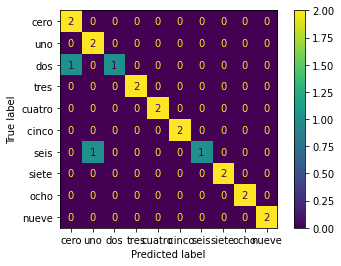

In [ ]:
disp_prueba = ConfusionMatrixDisplay(confusion_matrix = M_prueba,
                              display_labels =['cero', 'uno', 'dos', 'tres', 'cuatro', ' cinco', 'seis', 'siete', 'ocho', 'nueve'])
disp_prueba.plot()
plt.show()

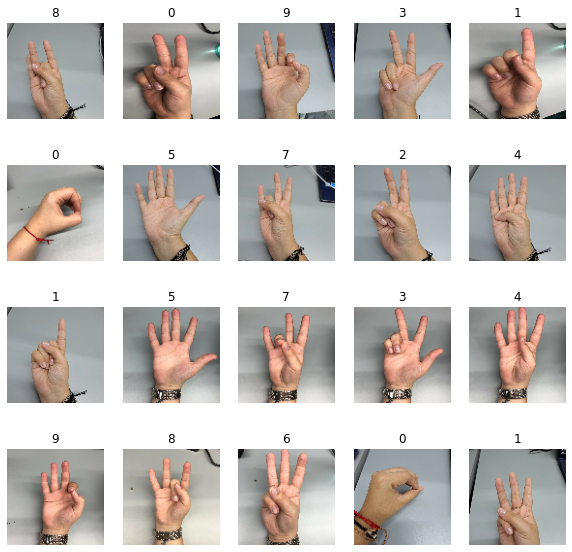

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(0,20):
  plt.subplot(4,5,i+1)
  plt.imshow(x_prueba_n[i])
  plt.title(p_prueba[i].argmax())
  plt.axis("off")
plt.show()

In [ ]:
print(classification_report(y_prueba, p_prueba.argmax(1)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.67      1.00      0.80         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           0.90        20
   macro avg       0.93      0.90      0.89        20
weighted avg       0.93      0.90      0.89        20

